In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import remove_small_holes, skeletonize
import pandas as pd
from matplotlib import animation
from matplotlib import rcParams
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from pyfcd.fcd import calculate_carriers, fcd, normalize_image

THRESHOLD = 120
MAX_PIXEL_VALUE = 255
MM2_CALIBRATION = 1000*(924)*1e-6  #largo*(diametro) de la cabecilla [µm^2 -> mm^2]

plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
# rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR

# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'
# rcParams['savefig.pad_inches'] = 0.05

In [2]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, PRUEBA=False, nombre='BINARY', threshold = THRESHOLD):
    # im_binary = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    _, im_binary = cv.threshold(frame, threshold, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def obtener_deformacion(vs, carriers, SHOW=False):
    camo_mask = [559,690,1120,1241] # ymin, ymax, xmin, xmax
    frame_count = int(vs.get(7))
    i=0
    maps = np.zeros(frame_count, dtype=object)
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:
            frame[camo_mask[0]:camo_mask[1],camo_mask[2]:camo_mask[3]] = 0
            frame = binarize(gris(frame[110:600,:]),threshold=140)
            height_map = fcd(frame, carriers)
            maps[i] = height_map
            if SHOW:
                cv.imshow('frame', frame)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
            i+=1
        else:
            break
        
    cv.destroyAllWindows()
    return maps

In [3]:
FILENAME='P1-2V-9Hz'

vs = cv.VideoCapture(f'videos/FCD/negro/{FILENAME}.mp4')
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret: 
        if i==0:
            ref_frame = gris(frame)
        cv.imshow('frame', frame)
        i+=1
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

(600.0, 110.0)

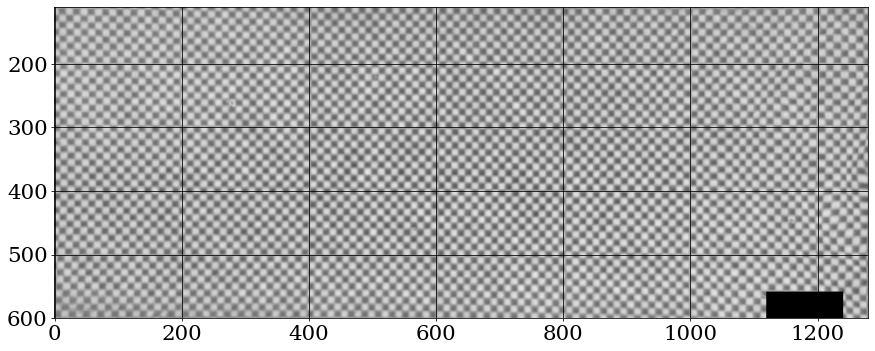

In [4]:
ref_frame[559:690,1120:1241] = 0
plt.imshow(ref_frame, cmap='gray')
plt.ylim([600,110])

In [5]:
camo_mask = [559,690,1120,1241] # ymin, ymax, xmin, xmax

vs = cv.VideoCapture(f'videos/FCD/negro/{FILENAME}.mp4')
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret:
        frame[camo_mask[0]:camo_mask[1],camo_mask[2]:camo_mask[3]] = 0
        frame = gris(frame[110:600,:])
        if i==0:
            ref_frame = frame
        cv.imshow('frame', frame)
        i+=1
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

In [6]:
vs = cv.VideoCapture(f'videos/FCD/negro/{FILENAME}.mp4')

carriers = calculate_carriers(ref_frame)

maps = obtener_deformacion(vs,carriers, SHOW=False)

In [7]:
max_height = max([maps[i].max() for i in np.arange(len(maps))])

norm = plt.Normalize(-max_height, max_height)
cmap = plt.colormaps.get_cmap('seismic')
colorscale = plt.cm.ScalarMappable(norm, cmap)

# for i in tqdm(np.arange(len(maps))[500:]):
#     fig, ax = plt.subplots()
#     curr_map = maps[i]
#     curr_map[camo_mask[0]:600,camo_mask[2]:camo_mask[3]] = 0
#     im = ax.imshow(maps[i],cmap=cmap, aspect='equal')

#     cbar_term = fig.colorbar(colorscale, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.0209)
#     cbar_term.ax.set_ylim(-max_height,max_height)
#     cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
#     cbar_term.ax.set_ylabel('Altura',labelpad=40)
#     fig.tight_layout()
#     # np.save(f'schlieren_maps/P1_2V_9Hz/frame_data/{str(i)}.npy',maps[i],allow_pickle=True)
#     fig.savefig(f'schlieren_maps/{FILENAME}/images/{str(i)}.tiff')
#     plt.close()

In [13]:
start = 0
finish = len(maps)
length = finish-start
x_len = maps[0].shape[1]
y_len = maps[0].shape[0]

map_fft = np.zeros((length,y_len,x_len), dtype=np.complex128)
reduced_maps = maps[start:finish]
for i in np.arange(len(reduced_maps)):
    for j in np.arange(y_len):
        map_fft[i][j] = np.fft.fft(reduced_maps[i][j,:])

(0.0, 640.0)

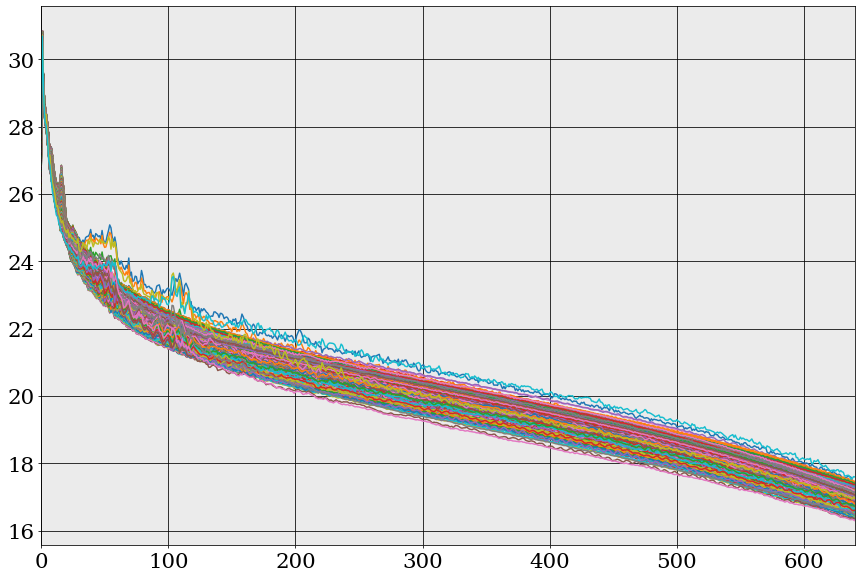

In [24]:
fig,ax = plt.subplots()

sum_fft = np.zeros(shape=map_fft[0].shape, dtype=np.float64)
for i in np.arange(len(map_fft)):
    for j in np.arange(y_len):
    #sum_fft+=(np.abs(np.fft.fftshift(map_fft[i]))**2)
        sum_fft[j]+=(np.abs(map_fft[i][j])**2)

for fftsum in sum_fft:
    ax.plot(np.log(fftsum))

ax.set_xlim([0,x_len//2])